In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import xgboost as xgb
import shap
import datetime
import warnings
warnings.filterwarnings("ignore")

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in 

Added: /Users/lsanchez/omath_mota_rulo


In [2]:
from data_scientia.features import train_data
from data_scientia.models.eval import eval_utils

In [3]:
data_ = train_data.get()

data_.shape

(10589, 63)

In [4]:
data_ = data_[data_['fecha'] < '2020-11-12']

In [5]:
contagios_cols = [x for x in data_.columns if 'contagios' in x]
contagios_7_cols = [x for x in contagios_cols if '7' in x]
contagios_15_cols = [x for x in contagios_cols if '15' in x]
contagios_cols = list(set(contagios_cols) - set(contagios_7_cols) - set(contagios_15_cols))

target = 'is_next_peak_in_15_days'
forbiden = list(set([
    'is_next_peak_in_7_days', 
    'is_next_peak_in_10_days', 
    'is_next_peak_in_15_days', 
    'is_next_peak_in_20_days', 
    'is_next_peak_in_30_days'
] + [
    x 
    for x in data_.columns
    if 'neighbor_hosp' in x
] + contagios_cols
))

In [6]:
date_data = data_[data_['fecha'] > data_['fecha'].quantile(.8)]

In [7]:
def plot_folds(X_train, X_val, X_oot):
    fig, ax = plt.subplots(1, 1, figsize=(18, 3))

    data_plot = X_train.reset_index()['fecha'].value_counts()
    data_plot.name = 'train'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True,
        ax=ax)

    data_plot = X_val.reset_index()['fecha'].value_counts()
    data_plot.name = 'val'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True, 
        ax=ax)

    data_plot = X_oot.reset_index()['fecha'].value_counts()
    data_plot.name = 'oot'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True, 
        ax=ax)
    ax.set_xlim(
        date2num(data_['fecha'].min()),
        date2num(data_['fecha'].max()))
    
    return fig, ax

[22:54:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.991403  0.360125  0.528334   6084.0  2210.0  0.865556
1             0.276529  0.987392  0.432056   1507.0  5381.0  0.865556
avg / total   0.849483  0.484653  0.509220   7591.0  7591.0  0.865556, 'val':              precision    recall  f1-score  support   pred       AUC
0             0.996176  0.603009  0.751262    864.0  523.0  0.833483
1             0.077957  0.935484  0.143921     31.0  372.0  0.833483
avg / total   0.964372  0.614525  0.730225    895.0  895.0  0.833483, 'oot':              precision    

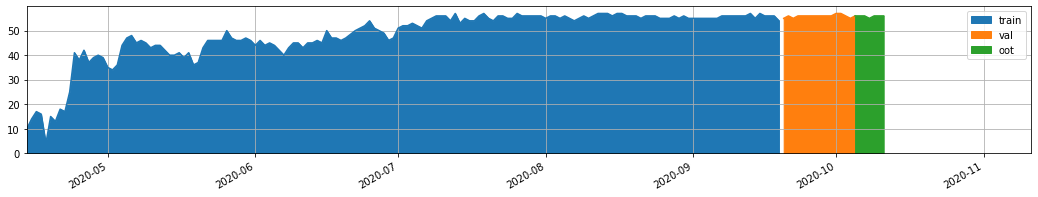

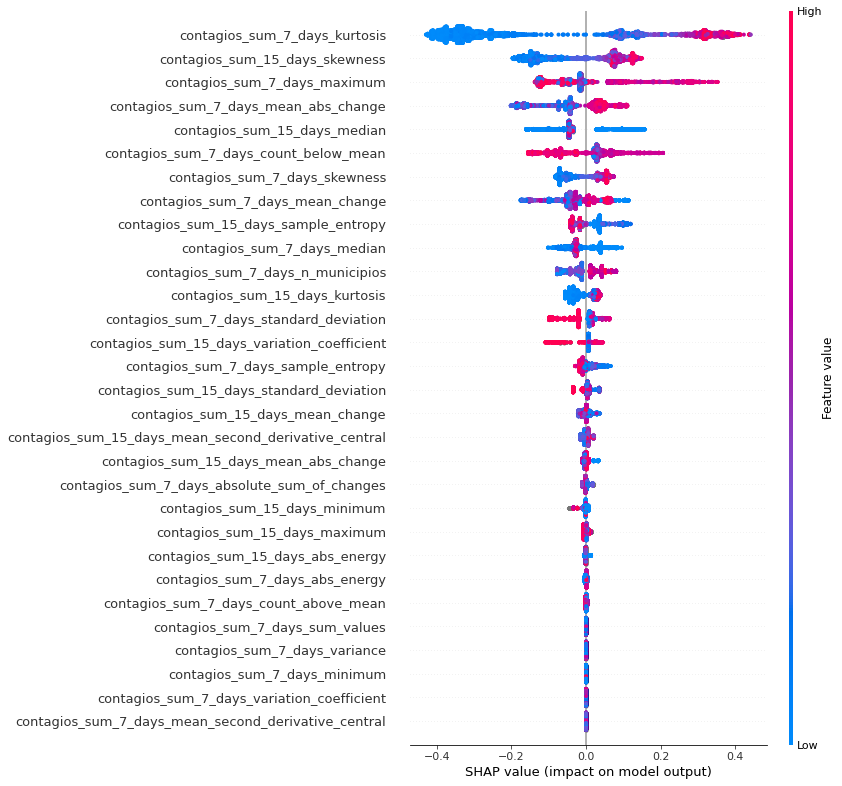

[22:54:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.998507  0.310478  0.473672   6461.0  2009.0  0.879077
1             0.254019  0.998026  0.404965   1520.0  5972.0  0.879077
avg / total   0.856717  0.441423  0.460586   7981.0  7981.0  0.879077, 'val':              precision    recall  f1-score  support   pred       AUC
0             0.989754  0.562282  0.717149    859.0  488.0  0.849007
1             0.078431  0.864865  0.143820     37.0  408.0  0.849007
avg / total   0.952121  0.574777  0.693474    896.0  896.0  0.849007, 'oot':              precision    

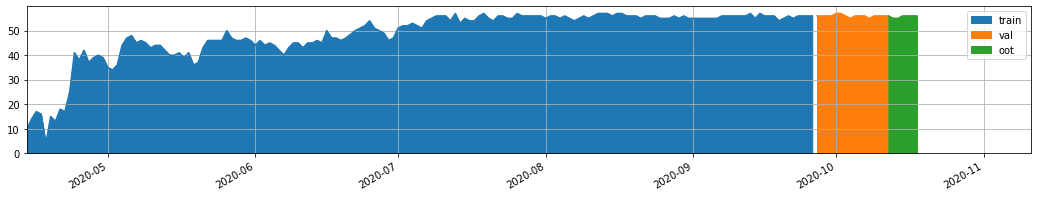

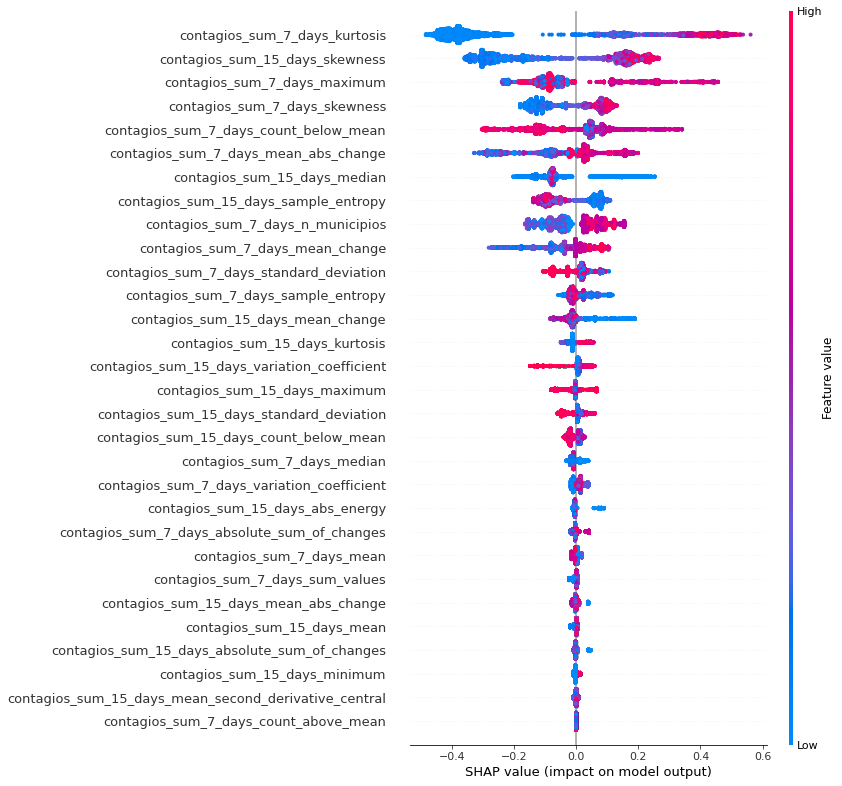

[22:55:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.995455  0.387325  0.557666   6785.0  2640.0  0.876001
1             0.268005  0.992177  0.422016   1534.0  5679.0  0.876001
avg / total   0.861315  0.498858  0.532652   8319.0  8319.0  0.876001, 'val':              precision    recall  f1-score  support   pred       AUC
0             1.000000  0.560894  0.718683    895.0  502.0  0.777654
1             0.118834  1.000000  0.212425     53.0  446.0  0.777654
avg / total   0.950737  0.585443  0.690379    948.0  948.0  0.777654, 'oot':              precision    

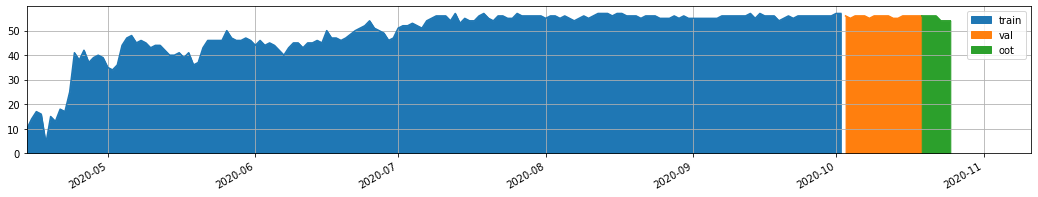

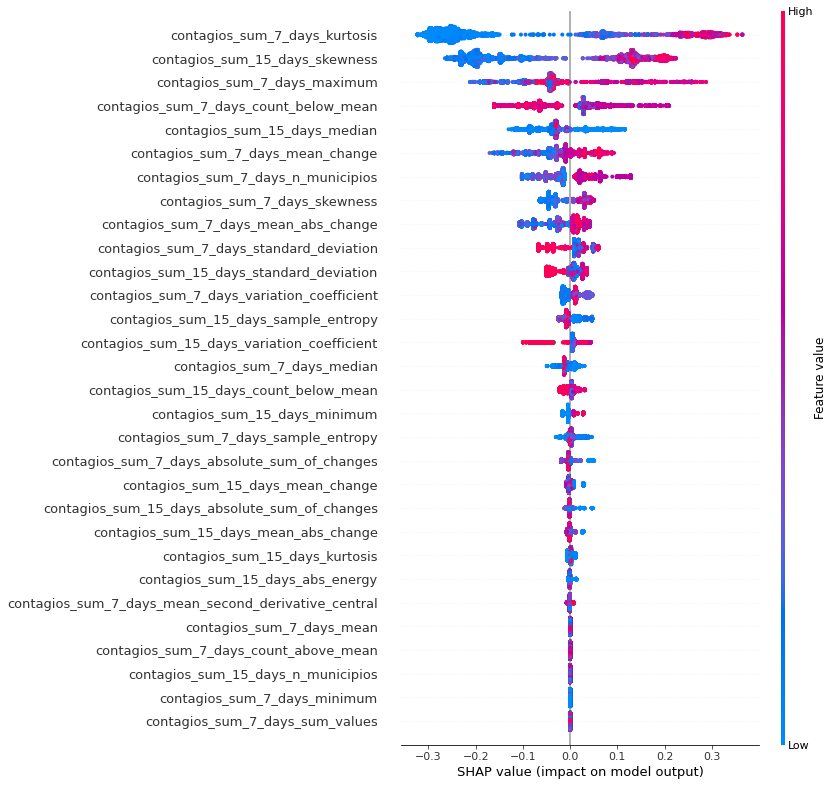

[22:55:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.992140  0.461538  0.630003   7111.0  3308.0  0.879838
1             0.283630  0.983139  0.440250   1542.0  5345.0  0.879838
avg / total   0.865881  0.554490  0.596188   8653.0  8653.0  0.879838, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.938356  0.742145  0.828796    923.0   730.0  0.695431
1             0.118519  0.415584  0.184438     77.0   270.0  0.695431
avg / total   0.875229  0.717000  0.779181   1000.0  1000.0  0.695431, 'oot':              precision

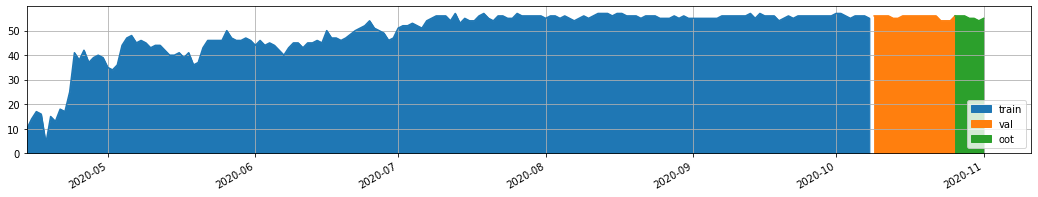

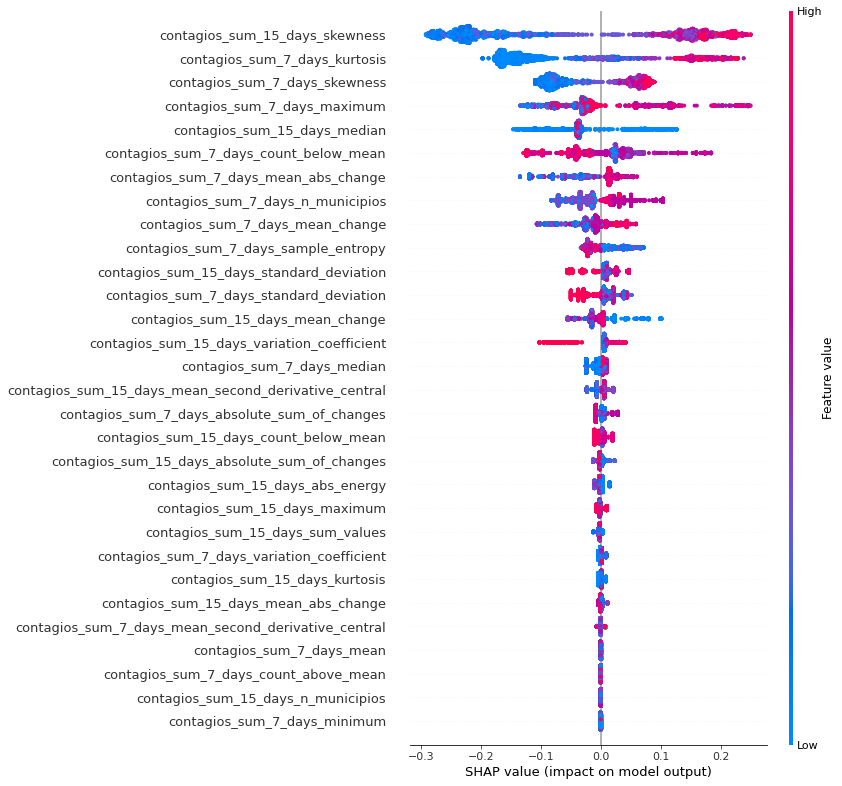

[22:55:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.994410  0.503233  0.668277   7424.0  3757.0  0.880515
1             0.294837  0.986564  0.453997   1563.0  5230.0  0.880515
avg / total   0.872742  0.587293  0.631009   8987.0  8987.0  0.880515, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.994126  0.695072  0.818127    974.0   681.0  0.840449
1             0.197297  0.948052  0.326622     77.0   370.0  0.840449
avg / total   0.935748  0.713606  0.782117   1051.0  1051.0  0.840449, 'oot':              precision

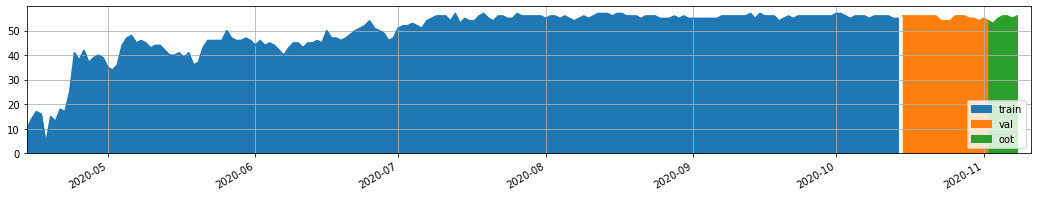

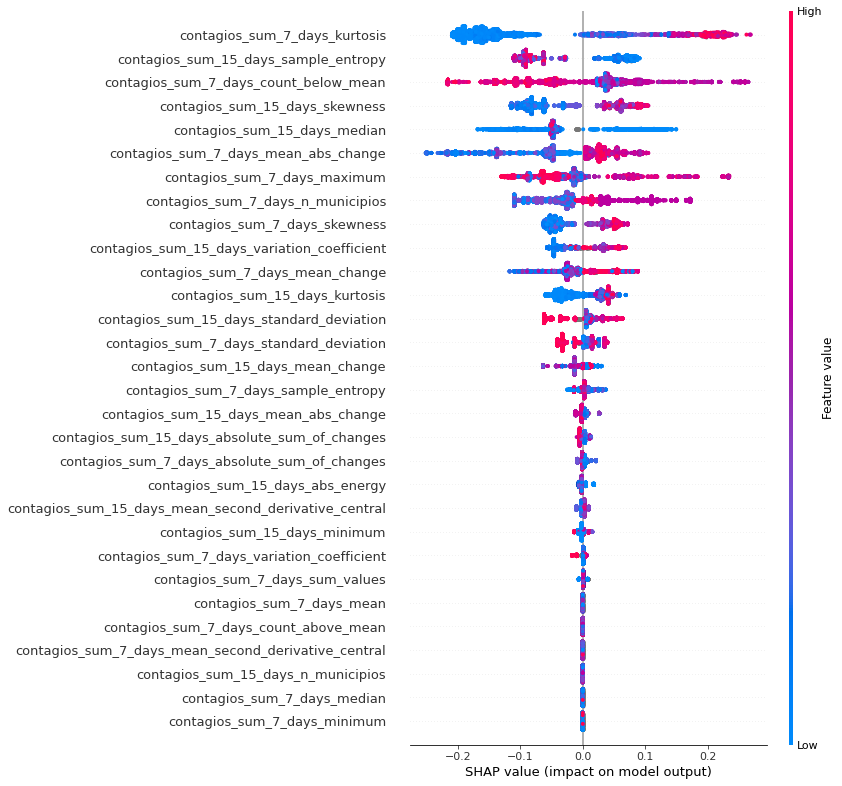

[22:55:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred      AUC
0             0.992008  0.494602  0.660091   7780.0  3879.0  0.87155
1             0.285091  0.980613  0.441752   1599.0  5500.0  0.87155
avg / total   0.871488  0.577460  0.622867   9379.0  9379.0  0.87155, 'val':              precision    recall  f1-score  support    pred       AUC
0             0.987973  0.581984  0.732484    988.0   582.0  0.838625
1             0.107991  0.877193  0.192308     57.0   463.0  0.838625
avg / total   0.939974  0.598086  0.703020   1045.0  1045.0  0.838625, 'oot':              precision    

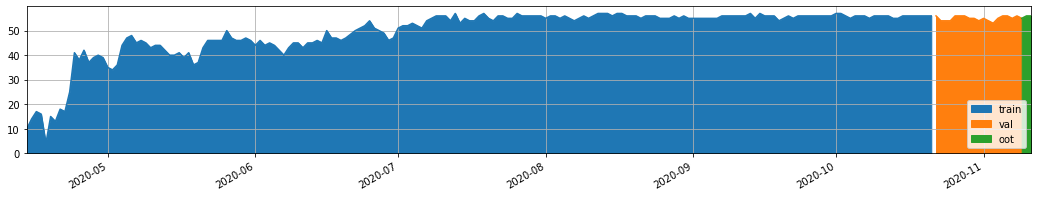

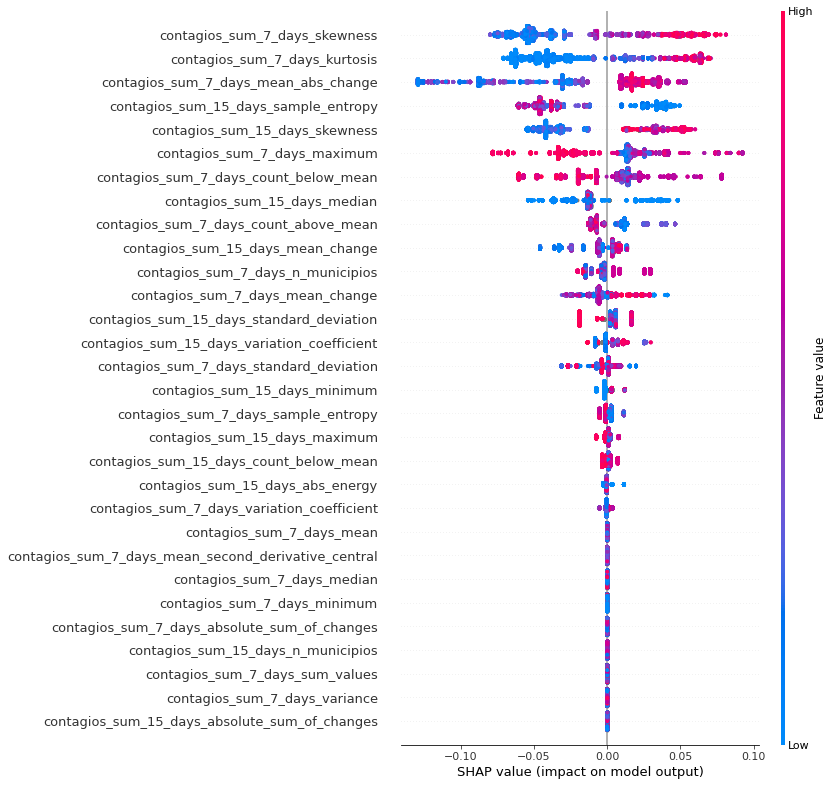

In [8]:
reports, feature_importance, dates = [], [], []
for date, oot in date_data.set_index('fecha').groupby(pd.Grouper(freq='7D')):
    dates.append(date)
    oot.reset_index(inplace=True)
    train = data_[data_['fecha'] <= date]

    oos_size = .1
    val_boundary = train['fecha'].quantile(1 - oos_size)

    val = train[train['fecha'] >= val_boundary]
    train = train[train['fecha'] < val_boundary]
    
    # Split data
    X_train = train.set_index(['fecha', 'nombre_hospital']).copy()
    X_train.drop(list(set(X_train.columns).intersection(forbiden)), axis=1, inplace=True)
    y_train = train.set_index(['fecha', 'nombre_hospital'])[target]

    X_val = val.set_index(['fecha', 'nombre_hospital']).copy()
    X_val.drop(list(set(X_val.columns).intersection(forbiden)), axis=1, inplace=True)
    y_val = val.set_index(['fecha', 'nombre_hospital'])[target]

    X_oot = oot.set_index(['fecha', 'nombre_hospital']).copy()
    X_oot.drop(list(set(X_oot.columns).intersection(forbiden)), axis=1, inplace=True)
    y_oot = oot.set_index(['fecha', 'nombre_hospital'])[target]
    
#     plot_folds(X_train, X_val, X_oot)
    
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    model = xgb.XGBClassifier(
        subsample=.7,
        col_subsample=.5,
        max_depth=4,
        learning_rate=.05,
        min_child_weight=100,
        scale_pos_weight=scale_pos_weight
    )

    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=['logloss', 'auc'],
        early_stopping_rounds=10,
        verbose=False)

    y_train_score = model.predict_proba(X_train)
    y_val_score = model.predict_proba(X_val)
    y_oot_score = model.predict_proba(X_oot)

    # Evaluate
    score_th = pd.Series(y_oot_score[:, 1]).quantile(.5)
    report_train = eval_utils.classification_report(
        y_true=y_train, 
        y_score=y_train_score, 
        y_pred=(y_train_score[:, 1] > score_th).astype(int))

    report_val = eval_utils.classification_report(
        y_true=y_val, 
        y_score=y_val_score, 
        y_pred=(y_val_score[:, 1] > score_th).astype(int))

    report_oot = eval_utils.classification_report(
        y_true=y_oot, 
        y_score=y_oot_score, 
        y_pred=(y_oot_score[:, 1] > score_th).astype(int))
    
    local_reports = {
        'train': report_train,
        'val': report_val,
        'oot': report_oot,
        'date': date
    }
    
    print(local_reports)
    reports.append(local_reports)
    
    plot_folds(X_train, X_val, X_oot)
    
    fig, ax = plt.subplots(1, 1)
    explainer = shap.TreeExplainer(model)
    
    shaps_values = pd.DataFrame(
        explainer.shap_values(X_train),
        columns=X_train.columns)

    shap.summary_plot(
        shaps_values.values, 
        X_train,
        max_display=30)
    
    feature_importance.append(shaps_values.abs().sum(axis=0).sort_values())
    
feature_importance = pd.DataFrame(
    feature_importance,
    index=dates)

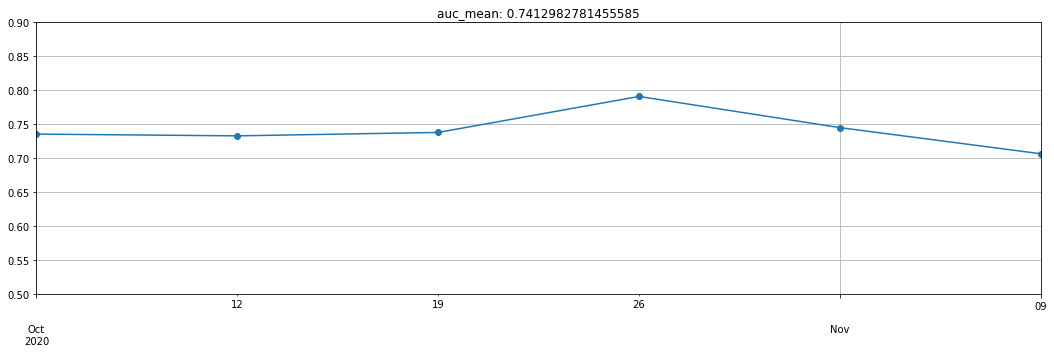

In [9]:
auc = pd.Series([r['oot']['AUC']['avg / total'] for r in reports])
auc.index = [r['date'] for r in reports]

auc_mean = auc.mean()

auc.plot(
    marker='o',
    grid=True,
    figsize=(18, 5),
    ylim=(.5, .9),
    title='auc_mean: %s' % auc_mean)

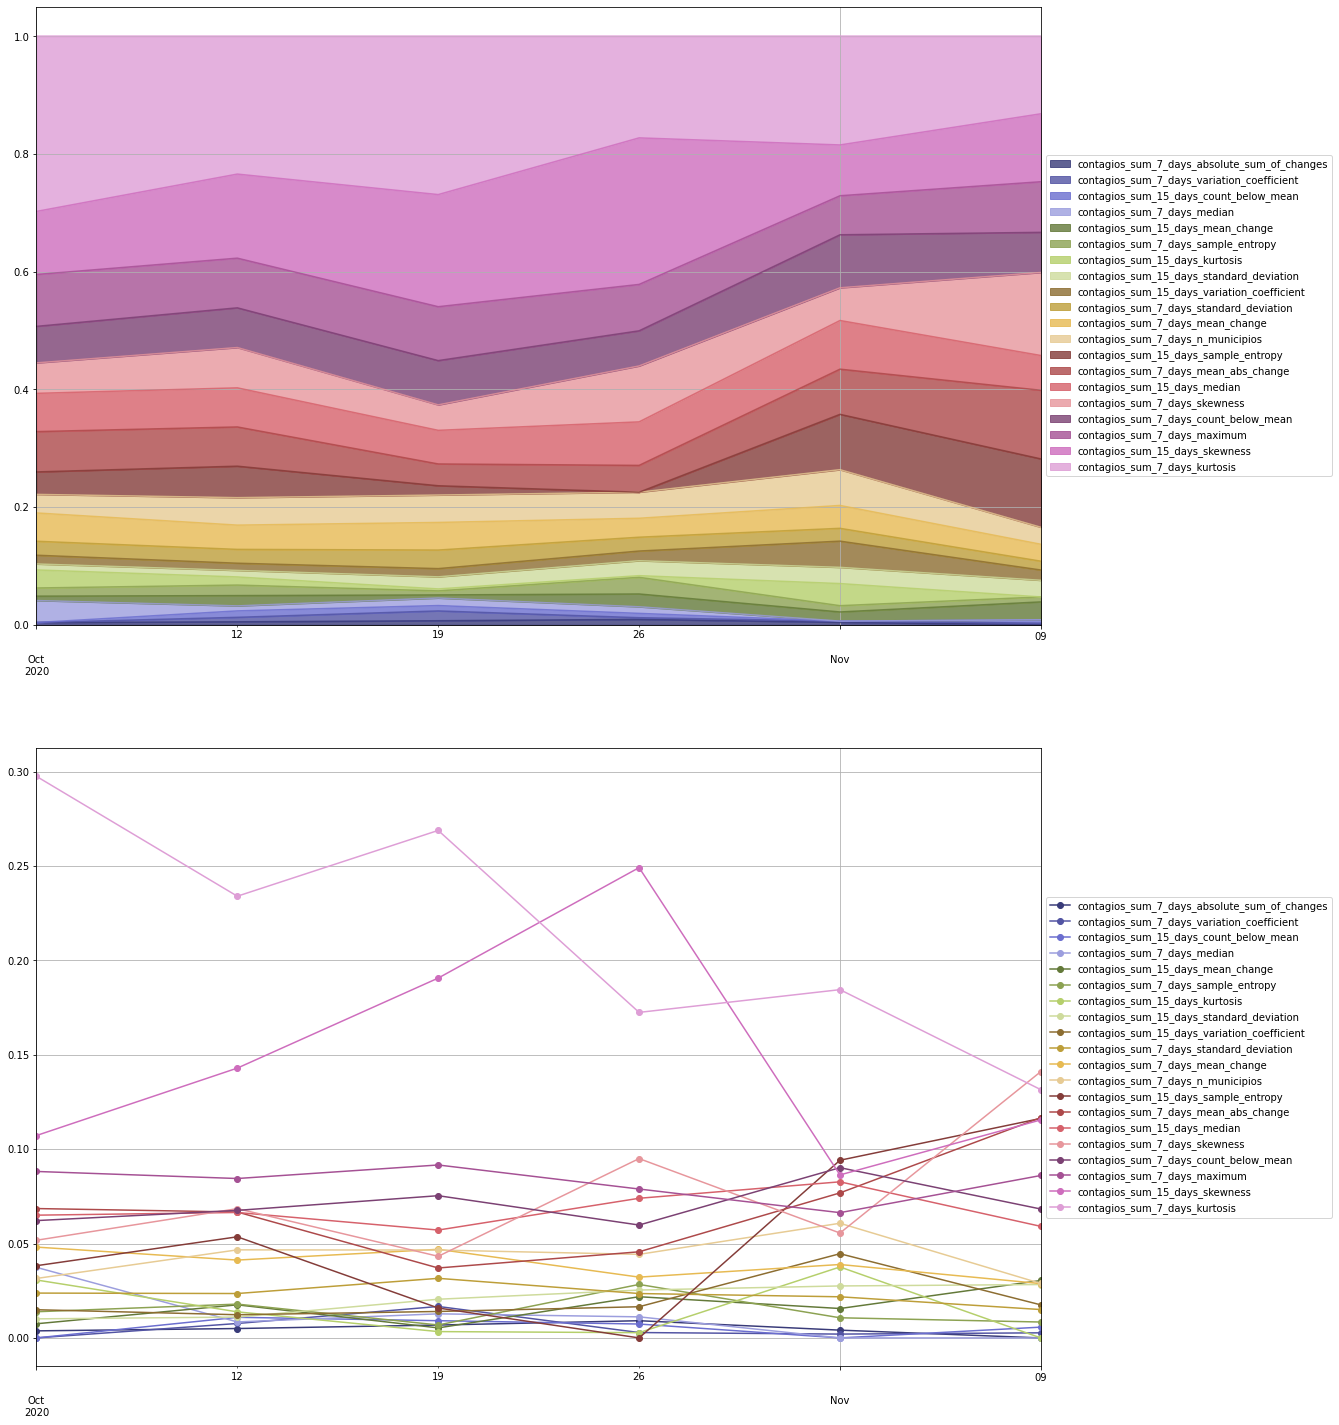

In [10]:
data_plot = feature_importance[feature_importance.sum().sort_values().iloc[-20:].index]
data_plot = (data_plot.T / data_plot.sum(axis=1)).T

fig, ax = plt.subplots(2, 1, figsize=(18, 25))
data_plot.plot(
    kind='area',
    stacked=True,
    ax=ax[0],
    grid=True,
    alpha=.8,
    cmap='tab20b')

data_plot.plot(
    marker='o', 
    ax=ax[1],
    cmap='tab20b',
    legend=False,
    grid=True)

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [11]:
data_plot.columns

Index(['contagios_sum_7_days_absolute_sum_of_changes',
       'contagios_sum_7_days_variation_coefficient',
       'contagios_sum_15_days_count_below_mean', 'contagios_sum_7_days_median',
       'contagios_sum_15_days_mean_change',
       'contagios_sum_7_days_sample_entropy', 'contagios_sum_15_days_kurtosis',
       'contagios_sum_15_days_standard_deviation',
       'contagios_sum_15_days_variation_coefficient',
       'contagios_sum_7_days_standard_deviation',
       'contagios_sum_7_days_mean_change', 'contagios_sum_7_days_n_municipios',
       'contagios_sum_15_days_sample_entropy',
       'contagios_sum_7_days_mean_abs_change', 'contagios_sum_15_days_median',
       'contagios_sum_7_days_skewness',
       'contagios_sum_7_days_count_below_mean', 'contagios_sum_7_days_maximum',
       'contagios_sum_15_days_skewness', 'contagios_sum_7_days_kurtosis'],
      dtype='object')